Nivell 1
- Exercici 1
Classifica els diferents vols utilitzant l'algorisme de K-means.

Nivell 2
- Exercici 2
Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.


Nivell 3
- Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import pydotplus
import graphviz
import datetime as dt
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
import time

#%matplotlib notebook per poder fer resize als plots interactius
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, adjusted_rand_score

from kneed import KneeLocator

# pas 1: lectura del bloc de dades i neteja

In [8]:
# FUNCIO per trobar gaps al format del DF (fora nan's, mida i forma)
def quick_analysis(df):
 #print('Data Types:')
 #print(df.dtypes)
 print('General Information:')
 flightsdf.info()
 print('Rows and Columns:')
 print(df.shape)
 print('Column Names:')
 print(df.columns)
 print('Null Values:')
 print(df.apply(lambda x: sum(x.isnull()) / len(df)))
 print('Samples')
 print(flightsdf.head())
 print(flightsdf.tail())

In [9]:
#lectura del bloc de dades
flightsdf=pd.read_csv('DelayedFlights.csv', index_col=0) #a vegades cal posar index_col=0 si no fos detectat inicialment

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
#elimino els que NO han volat (airtime=0 o cancellats)
flightsdf.drop(flightsdf[flightsdf.AirTime==0].index, inplace=True) #, axis=0, inplace=True)
flightsdf.drop(flightsdf[flightsdf.Cancelled!=0].index, inplace=True)

flightsdf.head(10)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
6,2008,1,3,4,1937.0,1830,2037.0,1940,WN,509,...,3.0,7.0,0,N,0,10.0,0.0,0.0,0.0,47.0
10,2008,1,3,4,706.0,700,916.0,915,WN,100,...,5.0,19.0,0,N,0,NaN,NaN,NaN,NaN,NaN
11,2008,1,3,4,1644.0,1510,1845.0,1725,WN,1333,...,6.0,8.0,0,N,0,8.0,0.0,0.0,0.0,72.0
15,2008,1,3,4,1029.0,1020,1021.0,1010,WN,2272,...,6.0,9.0,0,N,0,NaN,NaN,NaN,NaN,NaN
16,2008,1,3,4,1452.0,1425,1640.0,1625,WN,675,...,7.0,8.0,0,N,0,3.0,0.0,0.0,0.0,12.0


In [11]:
#reduccio dimensional d'entrada

pd.value_counts(flightsdf['Origin']) # es podria agafar només el TOP 20%, pel criteri de Pareto

pd.value_counts(flightsdf['Dest']) # es podria agafar només el TOP 20%, pel criteri de Pareto

ORD    108909
ATL    106872
DFW     70642
DEN     62989
LAX     59954
        ...  
INL         9
PIR         3
CYS         1
TUP         1
OGD         1
Name: Dest, Length: 304, dtype: int64

In [12]:
#creació de llista amb tail 100 a 'Origin' i 'Dest'
#selecció 100 amb menys trafic
#concatenació amb operador OR | en llista
#identificacio files a eliminar per contingut amb loc['Origin']o loc('Dest')

# Ho elimino per Origin
categorical=flightsdf['Origin'].value_counts()
print('Origins baseline')
print(categorical[-10:])
drop_values =  list(categorical.keys())[-150:]
flightsdf[~flightsdf['Origin'].str.contains('|'.join(drop_values))]
categorical=flightsdf['Origin'].value_counts()
print('Origins cleared')
print(categorical[-10:])

# Ho elimino per Dest
categorical=flightsdf['Dest'].value_counts()
print('Destinations baseline')
print(categorical[-10:])
drop_values =  list(categorical.keys())[-150:]
flightsdf[~flightsdf['Dest'].str.contains('|'.join(drop_values))]
categorical=flightsdf['Dest'].value_counts()
print('Destinations cleared')
print(categorical[-10:])

## NO FUNCIONA !!!!!!!!!!!!!!!!!!

Origins baseline
SUX    22
PLN    21
WYS    10
HTS    10
BLI     4
BJI     4
PIR     3
PUB     2
INL     1
TUP     1
Name: Origin, dtype: int64
Origins cleared
SUX    22
PLN    21
WYS    10
HTS    10
BLI     4
BJI     4
PIR     3
PUB     2
INL     1
TUP     1
Name: Origin, dtype: int64
Destinations baseline
ADK    30
SUX    28
ITH    16
BLI    13
BJI    12
INL     9
PIR     3
CYS     1
TUP     1
OGD     1
Name: Dest, dtype: int64
Destinations cleared
ADK    30
SUX    28
ITH    16
BLI    13
BJI    12
INL     9
PIR     3
CYS     1
TUP     1
OGD     1
Name: Dest, dtype: int64


In [13]:
flightsdf['DepDate'] =flightsdf['Year']*10000+flightsdf['Month']*100+flightsdf['DayofMonth']
#posa les dates a un enter per tal de manipular les hores

In [14]:
#Forço les hores a termes absoluts per poder estandarditzar només importa que les hores siguin CONTINUES
# .dt.time extreu de datetime64 a object amb HH:MM:SS, no interessa

flightsdf['DepTime'] = pd.to_datetime((flightsdf['DepTime']+flightsdf['DepDate']*10000), errors='coerce', format='%Y%m%d%H%M')
flightsdf['CRSDepTime'] = pd.to_datetime((flightsdf['CRSDepTime']+flightsdf['DepDate']*10000), errors='coerce', format='%Y%m%d%H%M')
flightsdf['ArrTime'] = pd.to_datetime((flightsdf['ArrTime']+flightsdf['DepDate']*10000), errors='coerce', format='%Y%m%d%H%M')
flightsdf['CRSArrTime'] = pd.to_datetime((flightsdf['CRSArrTime']+flightsdf['DepDate']*10000), errors='coerce', format='%Y%m%d%H%M')

flightsdf['DepDate']= pd.to_datetime(flightsdf['DepDate'], format='%Y%m%d')
#retorna datetimes arreu

In [15]:
flightsdf.drop(['Year', 'Month', 'DayofMonth', 'Cancelled','CancellationCode', 'TailNum', 'Diverted', 'UniqueCarrier', 'FlightNum'], axis=1, inplace=True)
flightsdf.dropna(inplace=True) #puc eliminar els NaN en general, que no tenen retard. Els podria posar en un *df* de control

# flightsdf.fillna(0) # o elimino els nan passant-los a 0
# com que UniqueCarrier concatenat amb FlightNum tenen assignades una hora de sortida determinada s'eliminen també

array([[<AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'ActualElapsedTime'}>,
        <AxesSubplot:title={'center':'CRSElapsedTime'}>,
        <AxesSubplot:title={'center':'AirTime'}>],
       [<AxesSubplot:title={'center':'ArrDelay'}>,
        <AxesSubplot:title={'center':'DepDelay'}>,
        <AxesSubplot:title={'center':'Distance'}>,
        <AxesSubplot:title={'center':'TaxiIn'}>],
       [<AxesSubplot:title={'center':'TaxiOut'}>,
        <AxesSubplot:title={'center':'CarrierDelay'}>,
        <AxesSubplot:title={'center':'WeatherDelay'}>,
        <AxesSubplot:title={'center':'NASDelay'}>],
       [<AxesSubplot:title={'center':'SecurityDelay'}>,
        <AxesSubplot:title={'center':'LateAircraftDelay'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

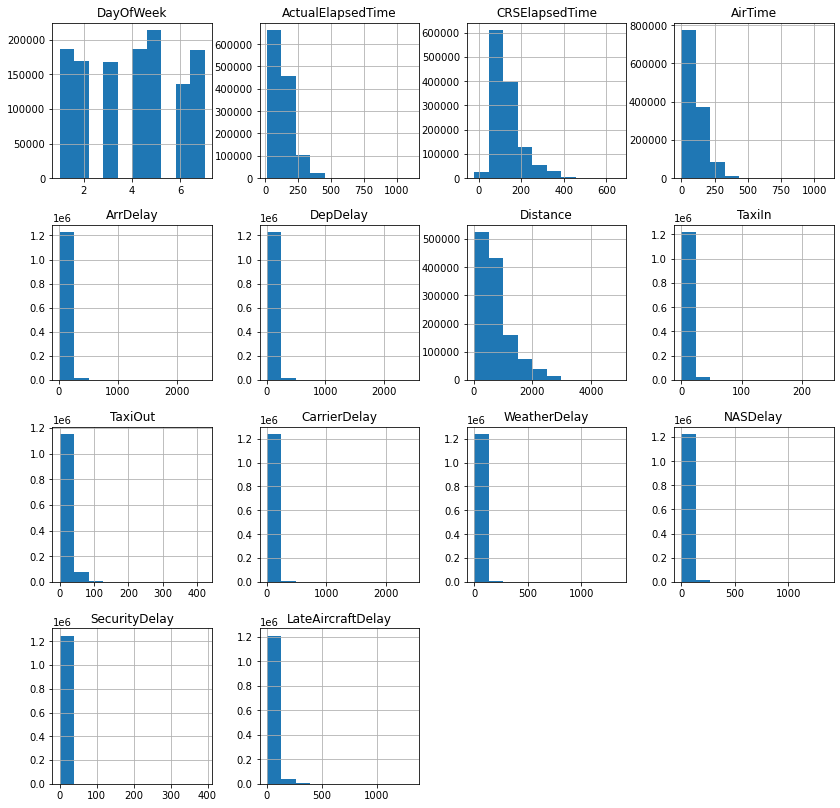

In [16]:
# grafico per tenir una idea de l'estat de les variables numèriques float o int
flightsdf[flightsdf.dtypes[(flightsdf.dtypes=="float64")|(flightsdf.dtypes=="int64")]
                        .index.values].hist(figsize=[14,14])

### NETEJA: preprocessing required: all vars must be numpy float64 compatible.
####  transforming timestamps to normalized numerical
nflightsdf=flightsdf[['DepDate','DepTime', 'CRSDepTime','ArrTime','CRSArrTime']]

In [17]:
# Function to convert datetime64 objects to float64 (normalitza, no estandarditza)

#PRE: entren datetime64 i int64

#transformo la darrera variable que necessito a float64
flightsdf['Distance']=flightsdf['Distance'].astype('float64')

# Normalize function the DF using min/max scaler (may use StandardScaler if so required)
def normalize(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dates_scaled = scaler.fit_transform(df)
    return dates_scaled

# Normalization call (1st datetimes, 2nd floats)
flightsdf[['DepDate','DepTime', 'CRSDepTime','ArrTime','CRSArrTime']] = normalize(flightsdf[['DepDate', 'DepTime', 'CRSDepTime','ArrTime','CRSArrTime']])
flightsdf[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay','DepDelay', 'Distance', 'TaxiIn', 'TaxiOut',
           'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay']] = normalize(flightsdf[['ActualElapsedTime','CRSElapsedTime', 'AirTime', 'ArrDelay','DepDelay',
                                                    'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
                                                    'SecurityDelay', 'LateAircraftDelay']])

#POST: surten float64 normalitzats. ALERTA: retards amb canvi de data poden muntar un sidral per DATE+n hores

In [18]:
quick_analysis(flightsdf)

General Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246117 entries, 4 to 7009718
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   DayOfWeek          1246117 non-null  int64  
 1   DepTime            1246117 non-null  float64
 2   CRSDepTime         1246117 non-null  float64
 3   ArrTime            1246117 non-null  float64
 4   CRSArrTime         1246117 non-null  float64
 5   ActualElapsedTime  1246117 non-null  float64
 6   CRSElapsedTime     1246117 non-null  float64
 7   AirTime            1246117 non-null  float64
 8   ArrDelay           1246117 non-null  float64
 9   DepDelay           1246117 non-null  float64
 10  Origin             1246117 non-null  object 
 11  Dest               1246117 non-null  object 
 12  Distance           1246117 non-null  float64
 13  TaxiIn             1246117 non-null  float64
 14  TaxiOut            1246117 non-null  float64
 15  CarrierDela

# queda transformar les 2 vars OBJECT i (dia de la setmana) a sparsematrix 

In [19]:
#codifico TOTES les columnes significatives
dummy_cols = ['DayOfWeek','Dest', 'Origin']
flightsdf = pd.get_dummies(flightsdf, columns = dummy_cols) 

#flightsdf.drop(['Dest', 'Origin'], axis=1, inplace=True)

In [20]:
# eliminant DepDelay, buscariem prediccio de ArrDelay
#flightsdf.drop(['DepDelay], axis=1, inplace=True)

# PAS 2: Preparació del model

1) estandarditzacio features
2) generacio del model
3) fit
4) validació

In [21]:
#removing 'ArrDelay' as target / label, mantenim flightsdf com a dataset COMPLET
targetdf=flightsdf['ArrDelay']
featuredf = flightsdf.drop(['ArrDelay'], axis=1)

### Cal reduir dimensionalment Array with shape (1246117, 627) + (1246117,) però no tinc memoria com per fer una PCA sobre tot el bloc ... faré una PCA sobre un SUBSET "training"


In [22]:
#defineixo
#dataset es flightsdf
#featuredf conté tot menys ArrDelay
#targetdf conté els valors dels retards ArrDelay

#separo en training i test: test size= proporció de TEST 
train_flights, test_flights, train_delay, test_delay = train_test_split(
    featuredf, targetdf, test_size=0.8, random_state=31416) 

In [23]:
# ho faig en pipeline per jugar, no seria necessari

preprocessor = Pipeline(
    [
        #("scaler", MinMaxScaler(feature_range=(-1, 1))), #already done in ETL
        ("pca", PCA(n_components=5, random_state=31)),
    ]
)


In [24]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=60,
               init="k-means++",
               n_init=50,
               max_iter=5,
               random_state=42,
           ),
       ),
   ]
)

In [25]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [26]:
pipe.fit(train_flights)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca',
                                  PCA(n_components=5, random_state=31))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=5, n_clusters=60, n_init=50,
                                         random_state=42))]))])

In [27]:
preprocessed_data = pipe["preprocessor"].transform(train_flights)
# no trobo tan util el pipeline si per treure resultats intermitjos has de recalcular-los
# potser millor el proper cop ho desglosso directament

In [28]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [29]:
predicted_labels # numpy array

array([13,  2, 50, ..., 17, 50, 32])

In [30]:
# The lowest SSE value
pipe["clusterer"]["kmeans"].inertia_

1285.2567521789927

In [31]:
silhouette_score(preprocessed_data, predicted_labels)

0.5311302241828035

In [32]:
adjusted_rand_score(train_delay, predicted_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


-0.00017627074720374646

In [33]:
# Final locations of the centroid
pipe["clusterer"]["kmeans"].cluster_centers_

array([[-0.1333302 , -0.21926686, -0.10045682,  0.79264039, -0.39601963],
       [-0.01860988, -0.13230498, -0.02550803,  0.04299059,  0.4944561 ],
       [ 0.03851232, -0.23853348, -0.6388821 , -0.51360448, -0.32351593],
       [ 0.35208459,  0.89374785,  0.03439718, -0.03523672, -0.0833041 ],
       [ 0.06455893, -0.26688223,  0.76295751, -0.32738409, -0.27178557],
       [-0.69227237,  0.87333664,  0.00816702, -0.01853875, -0.09752476],
       [-0.53809118, -0.15049085, -0.04976424,  0.05823704,  0.63077178],
       [ 1.12091304, -0.05080388,  0.02106874, -0.00173665,  0.10640009],
       [-0.95037923, -0.28736014,  0.73716319, -0.31116064, -0.28566947],
       [ 0.85389989, -0.19911868, -0.07521568,  0.77741119, -0.3842602 ],
       [ 1.10045567, -0.21715181, -0.61215056, -0.5308245 , -0.31012819],
       [ 1.0849506 , -0.24672091,  0.7890953 , -0.34358725, -0.25916492],
       [ 1.12421175, -0.10934372,  0.00333086,  0.02459524,  0.50952418],
       [-0.8927091 , -0.23446607, -0.1

In [34]:
# The number of iterations required to converge
pipe["clusterer"]["kmeans"].n_iter_

5

# 2 AMB CLUSTERING JERARQUIC

reduccio dimensional mitjançant PCA

PRE: ja es disposa de dataset split entre train i test, totalment normalitzat

In [35]:
print(train_flights.shape)

print(train_delay.shape)

print(test_flights.shape)

print(test_delay.shape)

(249223, 627)
(249223,)
(996894, 627)
(996894,)


In [36]:
pca = PCA(.999)

In [37]:
#fit al TRAINING SET
pca.fit(train_flights)

PCA(n_components=0.9999)

In [38]:
pca.n_components_

586

In [39]:
# per extensió aplicar mapping / transform a TRAINING I TEST SETS

train_flights = pca.transform(train_flights)
test_flights = pca.transform(test_flights)

print(train_flights.shape)

print(train_delay.shape)

print(test_flights.shape)

print(test_delay.shape)

(249223, 586)
(249223,)
(996894, 586)
(996894,)


In [40]:
### de 600 a 3 features n' hi ha prou com per reconstruir el 99% de l'espai !!!!!!!!
### de 600 a 586 features per fer el 99,99% (modelant el soroll probablement)

# havent aplicat les transformacions, es processa el dendrograma

MemoryError: Unable to allocate 231. GiB for an array with shape (31055927253,) and data type float64

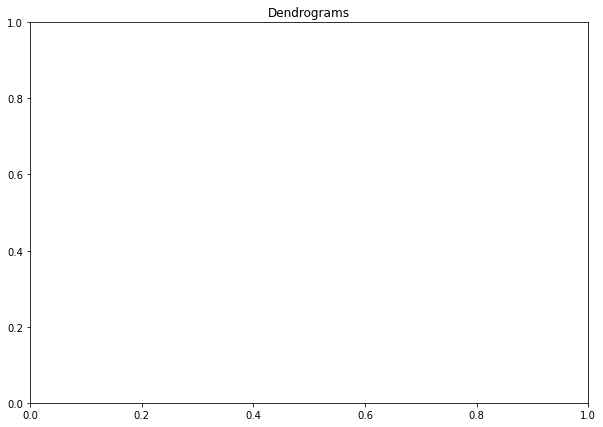

In [41]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(train_flights, method='ward'))

# no es pot fer un dendrograma ràpid per la seva elevada complexitat de components
#cal reduir l'espai amb una PCA, com anteriorment.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward')  
cluster.fit_predict(train_flights)

In [ ]:
plt.figure(figsize=(42, 14))  
plt.scatter(data_scaled['PCA1'], data_scaled['PCA2'], c=cluster.labels_, cmap=hsv) #cmap=hsv